In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager
import platform

# 포스트시즌 진출 팀 데이터

In [2]:
postseason = pd.read_csv("postseason.csv")
team = pd.read_csv('team.csv')

- 참석 팀 데이터

In [3]:
# 승리 팀 데이터 (연도, 팀 ID, 리그 ID)
winners = postseason[['year', 'team_id_winner', 'league_id_winner']].rename(
    columns={'team_id_winner': 'team_id', 'league_id_winner': 'league_id'}
)

In [4]:
# 패배 팀 데이터 (연도, 팀 ID, 리그 ID)
losers = postseason[['year', 'team_id_loser', 'league_id_loser']].rename(
    columns={'team_id_loser': 'team_id', 'league_id_loser': 'league_id'}
)

In [5]:
# 포시 진출 팀 데이터셋
post_team = pd.concat([winners, losers]).drop_duplicates().reset_index(drop=True)
post_team

,year,team_id,league_id
0,1884,PRO,NL
1,1885,CHC,NL
2,1886,STL,AA
3,1887,DTN,NL
4,1888,NYG,NL
...,...,...,...
421,2015,NYA,AL
422,2015,TEX,AL
423,2015,PIT,NL
424,2015,SLN,NL


- 결측값 정리

In [6]:
def fill_missing_values(df):
    # 문자형 결측값: 'unk'로 채우기
    df = df.apply(lambda col: col.fillna('unk') if col.dtype == 'object' else col)
    
    # 수치형 결측값: 열의 평균으로 채우기
    df = df.apply(lambda col: col.fillna(col.mean()) if col.dtype != 'object' else col)
    
    return df

In [7]:
team = fill_missing_values(team)

- 특성 정리

In [8]:
# 팀 지표 계산
def calculate_team_metrics(df):
    df['BA'] = df['h'] / df['ab']  # 타율
    df['OBP'] = (df['h'] + df['bb']) / (df['ab'] + df['bb'])  # 출루율
    df['SLG'] = (df['hr'] * 4) / df['ab']  # 장타율
    df['OPS'] = df['OBP'] + df['SLG']  # OPS
    df['WP'] = df['w'] / (df['w'] + df['l'])  # 승률
    df['PAR'] = df['r'] / df['bpf']  # 조정 득점
    df['PARA'] = df['ra'] / df['ppf']  # 조정 실점
    return df

team = calculate_team_metrics(team)

In [9]:
# 리그 평균 지표 계산
league_avg_metrics = team.groupby(['year', 'league_id']).agg({
    'BA': 'mean', 'OBP': 'mean', 'SLG': 'mean', 'OPS': 'mean', 
    'era' : 'mean','WP': 'mean', 'PAR': 'mean', 'PARA': 'mean'
}).reset_index()

In [10]:
# 데이터 결합
team_metrics_with_diff = pd.merge(team, league_avg_metrics, on=['year', 'league_id'], suffixes=('', '_league'))
performance_columns = ['BA', 'OBP', 'SLG', 'OPS', 'era', 'WP', 'PAR', 'PARA']

for col in performance_columns:
    team_metrics_with_diff[f'{col}_diff'] = team_metrics_with_diff[col] - team_metrics_with_diff[f'{col}_league']


In [11]:
team_metrics_with_diff.isnull().sum()

year            0
league_id       0
team_id         0
franchise_id    0
div_id          0
               ..
OPS_diff        0
era_diff        0
WP_diff         0
PAR_diff        0
PARA_diff       0
Length: 71, dtype: int64

##### 팀 이름 매핑

In [12]:
team_mapping = {
    'BS1': 'Boston Red Sox', 'CH1': 'Chicago Cubs', 'CL1': 'Cleveland Indians', 
    'FW1': 'Fort Wayne TinCaps', 'NY2': 'New York Mets', 'PH1': 'Philadelphia Phillies', 
    'RC1': 'Richmond Braves', 'TRO': 'Tampa Bay Rays', 'WS3': 'Washington Nationals', 
    'BL1': 'Baltimore Orioles', 'BR1': 'Boston Red Sox', 'BR2': 'Brooklyn Dodgers', 
    'MID': 'Minnesota Twins', 'WS4': 'Washington Nationals', 'BL4': 'Baltimore Orioles', 
    'ELI': 'El Paso Chihuahuas', 'PH2': 'Philadelphia Phillies', 'WS5': 'Washington Nationals', 
    'CH2': 'Chicago White Sox', 'HR1': 'Houston Astros', 'KEO': 'Kansas City Royals', 
    'NH1': 'New York Yankees', 'PH3': 'Philadelphia Phillies', 'SL1': 'St. Louis Cardinals', 
    'SL2': 'St. Louis Cardinals', 'WS6': 'Washington Nationals', 'BSN': 'Boston Red Sox', 
    'CHN': 'Chicago Cubs', 'CN1': 'Chicago White Sox', 'HAR': 'Harrisburg Senators', 
    'LS1': 'Louisville Bats', 'NY3': 'New York Mets', 'PHN': 'Philadelphia Phillies', 
    'SL3': 'St. Louis Cardinals', 'IN1': 'Indianapolis Indians', 'ML2': 'Mobile BayBears', 
    'PRO': 'Providence Grays', 'BFN': 'Buffalo Bisons', 'CL2': 'Cleveland Indians', 
    'SR1': 'Syracuse Chiefs', 'TRN': 'Tennessee Smokies', 'WOR': 'Worcester Red Sox', 
    'DTN': 'Durham Bulls', 'BL2': 'Baltimore Orioles', 'CN2': 'Chicago White Sox', 
    'LS2': 'Louisville Bats', 'PH4': 'Philadelphia Phillies', 'PT1': 'Portland Sea Dogs', 
    'SL4': 'St. Louis Cardinals', 'CL5': 'Cleveland Indians', 'NY1': 'New York Yankees', 
    'NY4': 'New York Mets', 'PHI': 'Philadelphia Phillies', 'ALT': 'Albuquerque Isotopes', 
    'BLU': 'Buffalo Bisons', 'BR3': 'Boston Red Sox', 'BSU': 'Boston Red Sox', 'CHU': 'Chattanooga Lookouts', 
    'CNU': 'Cincinnati Reds', 'IN2': 'Indianapolis Indians', 'KCU': 'Kansas City Royals', 
    'MLU': 'Mobile BayBears', 'PHU': 'Philadelphia Phillies', 'RIC': 'Richmond Braves', 
    'SLU': 'St. Louis Cardinals', 'SPU': 'Spokane Indians', 'TL1': 'Tulsa Drillers', 
    'WIL': 'Wilmington Blue Rocks', 'WS7': 'Washington Nationals', 'WSU': 'Washington Nationals', 
    'SL5': 'St. Louis Cardinals', 'KCN': 'Kansas City Royals', 'WS8': 'Washington Nationals', 
    'CL3': 'Cleveland Indians', 'IN3': 'Indianapolis Indians', 'PIT': 'Pittsburgh Pirates', 
    'KC2': 'Kansas City Royals', 'CL4': 'Cleveland Indians', 'CL6': 'Cleveland Indians', 
    'BFP': 'Buffalo Bisons', 'BL3': 'Baltimore Orioles', 'BR4': 'Brooklyn Dodgers', 
    'BRO': 'Brooklyn Dodgers', 'BRP': 'Brooklyn Dodgers', 'BSP': 'Boston Red Sox', 
    'CHP': 'Chicago Cubs', 'CIN': 'Cincinnati Reds', 'CLP': 'Cleveland Indians', 
    'NYP': 'New York Yankees', 'PHP': 'Philadelphia Phillies', 'PTP': 'Portland Sea Dogs', 
    'RC2': 'Richmond Braves', 'SR2': 'Syracuse Chiefs', 'TL2': 'Tulsa Drillers', 
    'BS2': 'Boston Red Sox', 'CN3': 'Chicago White Sox', 'ML3': 'Mobile BayBears', 
    'WS9': 'Washington Nationals', 'BLN': 'Baltimore Orioles', 'LS3': 'Louisville Bats', 
    'SLN': 'St. Louis Cardinals', 'WAS': 'Washington Nationals', 'BLA': 'Baltimore Orioles', 
    'BOS': 'Boston Red Sox', 'CHA': 'Chicago White Sox', 'CLE': 'Cleveland Indians', 
    'DET': 'Detroit Tigers', 'MLA': 'Milwaukee Brewers', 'PHA': 'Philadelphia Phillies', 
    'WS1': 'Washington Nationals', 'SLA': 'St. Louis Cardinals', 'NYA': 'New York Yankees', 
    'BLF': 'Baltimore Orioles', 'BRF': 'Brooklyn Dodgers', 'BUF': 'Buffalo Bisons', 
    'CHF': 'Chicago Cubs', 'IND': 'Indianapolis Indians', 'KCF': 'Kansas City Royals', 
    'PTF': 'Portland Sea Dogs', 'SLF': 'St. Louis Cardinals', 'NEW': 'New York Mets', 
    'ML1': 'Mobile BayBears', 'BAL': 'Baltimore Orioles', 'KC1': 'Kansas City Royals', 
    'LAN': 'Los Angeles Angels', 'SFN': 'San Francisco Giants', 'LAA': 'Los Angeles Angels', 
    'MIN': 'Minnesota Twins', 'WS2': 'Washington Nationals', 'HOU': 'Houston Astros', 
    'NYN': 'New York Mets', 'CAL': 'California Angels', 'ATL': 'Atlanta Braves', 
    'OAK': 'Oakland Athletics', 'KCA': 'Kansas City Royals', 'MON': 'Montreal Expos', 
    'SDN': 'San Diego Padres', 'SE1': 'Seattle Mariners', 'ML4': 'Milwaukee Brewers', 
    'TEX': 'Texas Rangers', 'SEA': 'Seattle Mariners', 'TOR': 'Toronto Blue Jays', 
    'COL': 'Colorado Rockies', 'FLO': 'Florida Marlins', 'ANA': 'Anaheim Angels', 
    'ARI': 'Arizona Diamondbacks', 'MIL': 'Milwaukee Brewers', 'TBA': 'Tampa Bay Rays', 
    'MIA': 'Miami Marlins'
}

##### 처리

- 그래프 그리기

In [13]:
# 팀 성능 시각화 함수
def visualize_team_vs_post_team(year, team_name, team_data):
    # 팀 이름을 ID로 변환
    if team_name not in team_mapping.values() and team_name not in team_mapping.keys():
        print(f"팀 이름 '{team_name}'은 유효하지 않습니다.")
        return

    team_id = [key for key, value in team_mapping.items() if value == team_name] if team_name in team_mapping.values() else [team_name]
    
    # 팀 데이터 필터링
    team_data_for_year = team_data[(team_data['year'] == year) & (team_data['team_id'].isin(team_id))]

    if team_data_for_year.empty:
        print(f"{year}년 {team_name} 팀에 대한 데이터가 없습니다.")
        return

    # 성능 비교 지표
    performance_columns = ['BA', 'OBP', 'SLG', 'OPS', 'era', 'WP', 'PAR', 'PARA']
    diff = team_data_for_year[[f'{col}_diff' for col in performance_columns]].iloc[0].fillna(0).values

    # 한글 폰트 설정
    if platform.system() == "Windows":
        font_path = "C:/Windows/Fonts/malgun.ttf"
    elif platform.system() == "Darwin":  # macOS
        font_path = "/System/Library/Fonts/Supplemental/AppleGothic.ttf"
    else:  # Linux
        font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
    font_prop = font_manager.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = font_prop.get_name()

    # 각도 계산
    angles = np.linspace(0, 2 * np.pi, len(performance_columns), endpoint=False).tolist()
    diff = np.concatenate((diff, [diff[0]]))
    angles += angles[:1]

    # 그래프 생성
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    ax.fill(angles, diff, color='blue', alpha=0.25)
    ax.plot(angles, diff, color='blue', linewidth=2)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(performance_columns, fontsize=12, fontweight='bold')

    # 팀의 약어를 사용해 타이틀에 풀네임과 함께 표시
    team_abbr = team_id[0] if team_name in team_mapping.values() else team_name
    team_full_name = team_mapping.get(team_abbr, team_name)
    ax.set_title(f"{year}년 {team_abbr} ({team_full_name}) vs 포스트시즌 팀 평균", size=15, fontweight='bold')

    # 수치를 그래프에 표시
    for i in range(len(diff)-1):
        color = 'blue' if diff[i] < 0 else 'red'  # 음수는 파란색, 양수는 빨간색
        ax.text(angles[i], diff[i] + 0.05, f"{diff[i]:.2f}", ha='center', 
                va='center', fontsize=12, color=color, fontweight='bold')

    plt.show()

- 프로그램 반응 코드

In [14]:
def main():
    # 연도 입력 받기
    year = int(input("연도 입력: "))  
    
    # 해당 연도의 팀 목록 추출
    available_teams = team_metrics_with_diff[team_metrics_with_diff['year'] == year]['team_id'].unique()

    # 연도에 맞는 팀 목록 출력
    print("사용 가능한 팀 목록:")
    for abbr, full_name in team_mapping.items():
        # 팀 약어가 해당 연도의 팀 목록에 포함되어 있을 경우 출력
        if abbr in available_teams:
            print(f"{abbr}: {full_name}")

    # 팀 이름 또는 약어 입력 받기
    team_name = input("팀 이름 또는 약어 입력 (예: 'Boston Red Sox' 또는 'BOS'): ")  

    # 입력된 팀이 해당 연도에 존재하는지 확인
    if team_name not in available_teams and team_name not in team_mapping:
        print(f"{team_name}는 {year}년에 존재하지 않는 팀입니다. 다시 입력해주세요.")
        return

    # 팀 성능 시각화 호출
    visualize_team_vs_post_team(year, team_name, team_metrics_with_diff)

연도와 팀이름을 입력해주세요.
사용 가능한 팀 목록:
CHN: Chicago Cubs
PHI: Philadelphia Phillies
PIT: Pittsburgh Pirates
CIN: Cincinnati Reds
SLN: St. Louis Cardinals
WAS: Washington Nationals
BOS: Boston Red Sox
CHA: Chicago White Sox
CLE: Cleveland Indians
DET: Detroit Tigers
NYA: New York Yankees
BAL: Baltimore Orioles
LAN: Los Angeles Angels
SFN: San Francisco Giants
LAA: Los Angeles Angels
MIN: Minnesota Twins
HOU: Houston Astros
NYN: New York Mets
ATL: Atlanta Braves
OAK: Oakland Athletics
KCA: Kansas City Royals
SDN: San Diego Padres
TEX: Texas Rangers
SEA: Seattle Mariners
TOR: Toronto Blue Jays
COL: Colorado Rockies
ARI: Arizona Diamondbacks
MIL: Milwaukee Brewers
TBA: Tampa Bay Rays
MIA: Miami Marlins


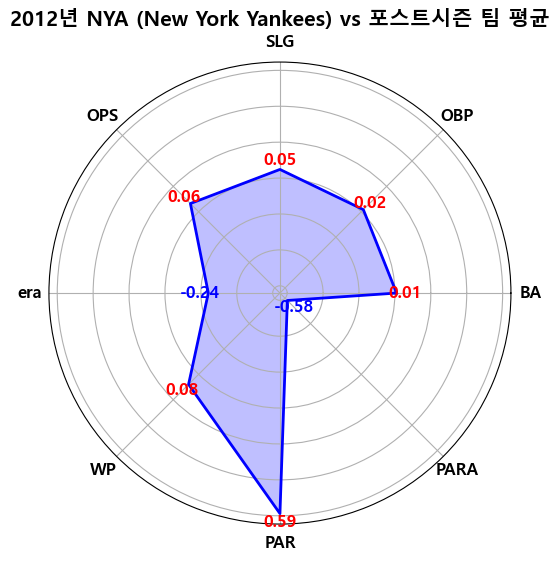

In [26]:
# 프로그램 실행
if __name__ == "__main__":
    print("연도와 팀이름을 입력해주세요.")
    main()

In [21]:
post_team[post_team['year']==2013]

,year,team_id,league_id
198,2013,TBA,AL
199,2013,BOS,AL
200,2013,DET,AL
201,2013,PIT,NL
202,2013,SLN,NL
203,2013,LAN,NL
411,2013,CLE,AL
412,2013,OAK,AL
413,2013,CIN,NL
414,2013,ATL,NL
